In [1]:
from ContentUtil import ContentUtil
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

In [2]:
ctl = ContentUtil()
AI_data, Not_AI_data = ctl.loadData("datasets/AI/", "datasets/NOT/")
AI = np.array(AI_data).reshape(-1,1)
Not_AI = np.array(Not_AI_data).reshape(-1,1)
data = np.concatenate((AI, Not_AI), axis=0)
label = ["AI"]*AI.shape[0]+["NOT"]*Not_AI.shape[0]
label = np.array(label).reshape(-1,1)

In [3]:
dataset = np.concatenate((data,label),axis=1)
df = pd.DataFrame(dataset,columns=["data","label"])
dfshf = shuffle(df).reset_index(drop=True)
dfshf.head()

,data,label
0,Danish computer scientistCorinna Cortes is a D...,AI
1,The examples and perspective in this article m...,NOT
2,Md Uzzal Hossain is a Bangladeshi Artist Born ...,NOT
3,Mesowear is a method used in different branche...,NOT
4,The California Resale Royalty Act Civil Code s...,NOT


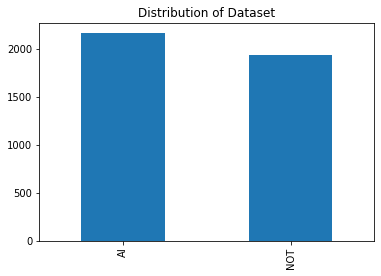

In [8]:
df["label"].value_counts().plot(kind='bar',title="Distribution of Dataset")

In [9]:
df["length"] = df["data"].apply(lambda x:len(x.strip().split()))

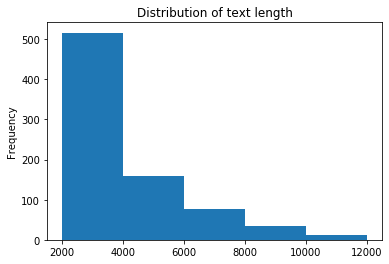

In [23]:
df["length"].plot.hist(bins=[2000,4000,6000,8000,10000,12000],title="Distribution of text length")

In [25]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
stopwords = ctl.getStopWords()

In [28]:
def preprocessing(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(str(text))
    newtext = ""
    for w in tokens:
        if w not in stopwords and len(w)>1:
            newtext = newtext + " " + stemmer.stem(w)
    return newtext

In [29]:
df["tokens"]=df["data"].apply(preprocessing)

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2

In [45]:
vectorizer = TfidfVectorizer(analyzer='word',max_features=10000,ngram_range=(1, 2),stop_words=stopwords)
tfidf = vectorizer.fit_transform(df['tokens'])
word_reduced = SelectKBest(chi2,k=5000).fit_transform(tfidf, label)
importance = np.argsort(np.asarray(tfidf.sum(axis=0)).ravel())[::-1]
tfidf_feature_names = np.array(vectorizer.get_feature_names())

In [47]:
n_top = 200
topwords = tfidf_feature_names[importance[:n_top]]
topwords

array(['mw', 'mw parser', 'parser output', 'parser', 'output', 'art',
       'comput', 'system', 'robot', 'learn', 'sidebar', 'human',
       'research', 'output sidebar', 'model', 'work', 'cell', 'cs',
       'univers', 'intellig', 'thi', 'articl', 'develop', 'data',
       'biolog', 'base', 'organ', 'ai', 'scienc', 'imag', 'process',
       'speci', 'design', 'book', 'paint', 'artist', 'artifici', 'sourc',
       'machin', 'citat', 'technolog', 'remov', 'program', 'inform',
       'output cs', 'exampl', 'studi', 'style', 'languag', 'network',
       'size', 'algorithm', 'left', 'award', 'function', 'agent',
       'artifici intellig', 'right', 'space', 'form', 'set', 'creat',
       'knowledg', 'method', 'game', 'natur', 'term', 'state', 'anim',
       'help', 'interact', 'object', 'lock', 'type', 'margin', 'engin',
       'top', 'theori', 'project', 'applic', 'group', 'plant', 'templat',
       'world', 'control', 'field', 'problem', 'product', 'softwar',
       'institut', 'messag'

In [48]:
X, y = word_reduced, df["label"]

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2021)

In [65]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.get_cmap("Blues")):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [70]:
def cv_all(word_reduced, label):
    svm_cv_results = cross_validate(svm_clf, word_reduced, label,
                                    scoring=['accuracy', 'recall_macro', 'precision_macro', 'f1_macro'], cv=10,
                                    return_train_score=False,return_estimator=True)
    nb_cv_results = cross_validate(nb_clf, word_reduced, label,
                                   scoring=['accuracy', 'recall_macro', 'precision_macro', 'f1_macro'], cv=10,
                                   return_train_score=False,return_estimator=True)
    dt_cv_results = cross_validate(dt_clf, word_reduced, label,
                                   scoring=['accuracy', 'recall_macro', 'precision_macro', 'f1_macro'], cv=10,
                                   return_train_score=False,return_estimator=True)
    knn_cv_results = cross_validate(knn_clf, word_reduced, label,
                                    scoring=['accuracy', 'recall_macro', 'precision_macro', 'f1_macro'], cv=10,
                                    return_train_score=False,return_estimator=True)
    rfc_cv_results = cross_validate(rfc_clf, word_reduced, label,
                                    scoring=['accuracy', 'recall_macro', 'precision_macro', 'f1_macro'], cv=10,
                                    return_train_score=False,return_estimator=True)
    return svm_cv_results, nb_cv_results, dt_cv_results, knn_cv_results, rfc_cv_results

In [68]:
from mlxtend.evaluate import paired_ttest_kfold_cv
from scipy.stats import friedmanchisquare
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.multiclass import unique_labels

In [69]:
# build classifiers
seed = 2021
svm_clf = LinearSVC(random_state=seed, tol=1e-5)
nb_clf = MultinomialNB()
dt_clf = DecisionTreeClassifier(criterion='entropy', max_features='sqrt', random_state=seed)
knn_clf = KNeighborsClassifier(n_neighbors=7, n_jobs=2)
rfc_clf = RandomForestClassifier(random_state=seed)

In [79]:
classes = set(y)
classes

{'AI', 'NOT'}

In [93]:
r1, r2, r3, r4, r5 = cv_all(X_train,y_train)

In [94]:
def predict_and_plot(clf,X_test,y_test,title):
    ind = np.argmax(clf["test_accuracy"])
    final_clf = clf['estimator'][ind]
    y_pred = final_clf.predict(X_test)
    cfm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cfm,classes,title=title)

Confusion matrix, without normalization


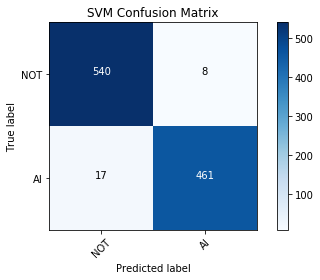

In [95]:
predict_and_plot(r1,X_test,y_test,"SVM Confusion Matrix")

Confusion matrix, without normalization


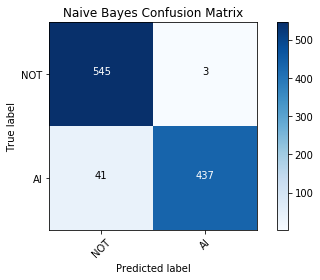

In [96]:
predict_and_plot(r2,X_test,y_test,"Naive Bayes Confusion Matrix")

Confusion matrix, without normalization


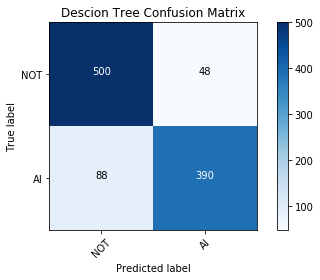

In [97]:
predict_and_plot(r3,X_test,y_test,"Descion Tree Confusion Matrix")

Confusion matrix, without normalization


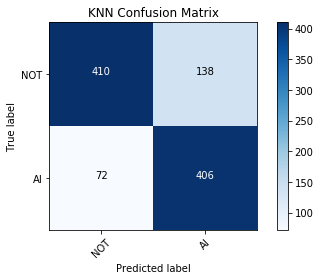

In [98]:
predict_and_plot(r4,X_test,y_test,"KNN Confusion Matrix")

Confusion matrix, without normalization


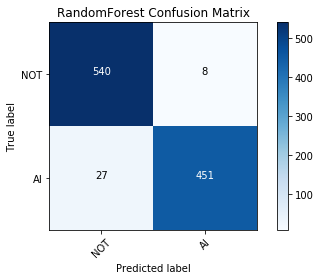

In [99]:
predict_and_plot(r5,X_test,y_test,"RandomForest Confusion Matrix")

In [100]:
def plot_classification_report(clf, X, y):
    class_names = unique_labels(y)
    error_evaluation = cross_val_predict(estimator=clf, X=X, y=y, cv=10)
    print(classification_report(y, error_evaluation, target_names=class_names))

In [102]:
plot_classification_report(svm_clf, X_train, y_train)


              precision    recall  f1-score   support

          AI       0.97      0.97      0.97      1614
         NOT       0.97      0.97      0.97      1463

    accuracy                           0.97      3077
   macro avg       0.97      0.97      0.97      3077
weighted avg       0.97      0.97      0.97      3077



In [103]:
plot_classification_report(rfc_clf, X_train, y_train)

              precision    recall  f1-score   support

          AI       0.95      0.97      0.96      1614
         NOT       0.96      0.94      0.95      1463

    accuracy                           0.95      3077
   macro avg       0.95      0.95      0.95      3077
weighted avg       0.95      0.95      0.95      3077



In [106]:
# the function of plotting learning curve
def plot_learning_curve(clf, X, y, clf_name,size):
    train_sizes, train_scores, valid_scores = learning_curve(clf, X, y,
                                                             train_sizes=size, cv=10)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(valid_scores, axis=1)
    test_scores_std = np.std(valid_scores, axis=1)
    plt.grid()
    plt.title("Learning curve for " + clf_name)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.xlabel("Sample Size")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.show()

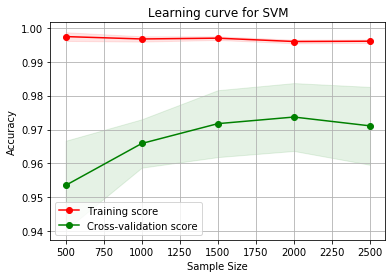

In [108]:
plot_learning_curve(svm_clf, X_train, y_train, "SVM",[500,1000,1500,2000,2500])

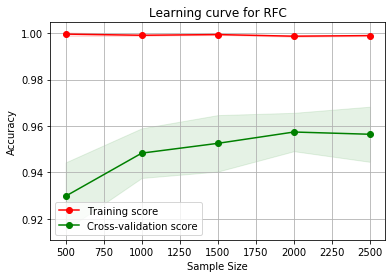

In [110]:
plot_learning_curve(rfc_clf, X_train, y_train, "RFC",[500,1000,1500,2000,2500])

#### Using paired t-test to check if two classifiers have difference

In [112]:
def paired_ttest(X, y, clf1, clf2):
    t, p = paired_ttest_kfold_cv(estimator1=clf1, estimator2=clf2, X=X, y=np.array(y))
    print('t statistic: %.3f' % t)
    print('p value: %.3f' % p)

Given null hypothesis and alternative hypothesis <br>
H0 : means difference between two classifier is 0 <br>
H1 : means difference between two classifier is not 0 <br>

In [113]:
print("t test for classfiers SVM and RFC")
paired_ttest(X, y, svm_clf, rfc_clf)

t test for classfiers SVM and RFC
t statistic: 2.758
p value: 0.022


P value is 0.022 < 0.05, reject the null hypothesis H0. <br> thus, two classifier have siginificant difference